In [91]:
import script_utils as utils

MODEL = "anthropic-claude-sonnet-4.5"

tasks = utils.get_tasks(MODEL, remove_corrupted=True)

2026-01-26 22:31:12.462 | WARNING  | script_utils:get_tasks:65 - Warning: Task ID 58565672-7bfe-48ab-b828-db349231de6b in domain multi_apps not found in ground truth.
2026-01-26 22:31:12.463 | WARNING  | script_utils:get_tasks:70 - Warning: Only 347 tasks found, but 351 expected from ground truth.


In [30]:
count = 0
for task in tasks:
    if "error_reasons" in task and len(task["error_reasons"]) > 0:
        print(task["error_reasons"])
        break
print(count/len(tasks))

['Reasoning (Wrong Action)']
0.0


Total success rate: 78.80% (275/349)


,success_rate_%
domain,
vs_code,91.304348
os,90.909091
libreoffice_calc,89.130435
chrome,88.636364
vlc,87.500000
libreoffice_writer,86.363636
thunderbird,80.000000
libreoffice_impress,78.723404
gimp,70.833333


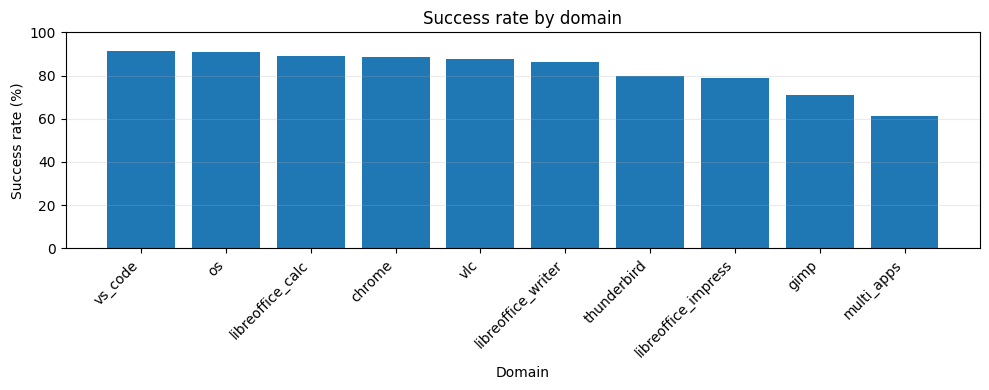

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(tasks).copy()
if df.empty:
    raise ValueError("No tasks found — run Cell 3 first.")

if "domain" not in df.columns or "success" not in df.columns:
    raise ValueError(f"Expected columns ['domain', 'success'] but got: {list(df.columns)}")

df["success_bool"] = df["success"].astype(bool)

# Total success rate (%)
total_success_rate = df["success_bool"].mean() * 100
print(f"Total success rate: {total_success_rate:.2f}% ({df['success_bool'].sum()}/{len(df)})")

# Success rate (%) by domain
success_rate = (
    df.groupby("domain")["success_bool"]
      .mean()
      .mul(100)
      .sort_values(ascending=False)
)

display(success_rate.rename("success_rate_%").to_frame())

plt.figure(figsize=(10, 4))
plt.bar(success_rate.index.astype(str), success_rate.values)
plt.ylabel("Success rate (%)")
plt.xlabel("Domain")
plt.ylim(0, 100)
plt.title("Success rate by domain")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

In [36]:
# Define category bundles
category_mapping = {
    'os': 'OS',
    'libreoffice_calc': 'Office',
    'libreoffice_writer': 'Office',
    'libreoffice_impress': 'Office',
    'chrome': 'Daily',
    'vlc': 'Daily',
    'thunderbird': 'Daily',
    'vs_code': 'Professional',
    'gimp': 'Professional',
    'multi_apps': 'Workflow',
}

# Map domains to categories
df['category'] = df['domain'].str.lower().map(category_mapping)

# Calculate stats by category
category_stats = df.groupby('category').agg(
    total_tasks=('success_bool', 'count'),
    successful_tasks=('success_bool', 'sum'),
    success_rate=('success_bool', 'mean')
).reset_index()

category_stats['success_rate'] = (category_stats['success_rate'] * 100).round(2)
category_stats = category_stats.sort_values('success_rate', ascending=False)

# Add totals row
totals = pd.DataFrame({
    'category': ['TOTAL'],
    'total_tasks': [df['success_bool'].count()],
    'successful_tasks': [df['success_bool'].sum()],
    'success_rate': [round(df['success_bool'].mean() * 100, 2)]
})
category_stats = pd.concat([category_stats, totals], ignore_index=True)

# Display the table
category_stats.columns = ['Category', 'Total Tasks', 'Successful', 'Success Rate (%)']
display(category_stats)

,Category,Total Tasks,Successful,Success Rate (%)
0,OS,22,20,90.91
1,Daily,75,65,86.67
2,Office,115,97,84.35
3,Professional,47,38,80.85
4,Workflow,90,55,61.11
5,TOTAL,349,275,78.80


In [80]:
all_error_reasons = []
for task in tasks:
    error_reasons = task.get("error_reasons", [])
    if len(error_reasons) > 0:
        if "Limit Reached" not in error_reasons and len(error_reasons) >= 50:
            error_reasons.append("Limit Reached")
        all_error_reasons.append(error_reasons)

In [81]:
error_map = {}
for reasons in all_error_reasons:
    for reason in reasons:
        if reason not in error_map:
            error_map[reason] = 0
        error_map[reason] += 1
error_map

{'Task Incompleteness': 6,
 'Reasoning (Wrong Action)': 25,
 'UI Comprehension': 28,
 'Task Ambiguity / Misunderstanding': 1,
 'Knowledge': 23,
 'Looping / Repetition': 6,
 'Infeasible': 11,
 'Hallucinated Action': 10,
 'Localization': 12,
 'Limit Reached': 30}

In [92]:
input_tokens, cached_input_tokens, output_tokens = 0, 0, 0
for task in tasks:
    input_tokens += task["usage_input_tokens"]
    cached_input_tokens += task["usage_cached_input_tokens"]
    output_tokens += task["usage_output_tokens"]

In [93]:
print(f"Input tokens: {input_tokens}")
print(f"Cached input tokens: {cached_input_tokens}")
print(f"Output tokens: {output_tokens}")

Input tokens: 280030
Cached input tokens: 20470833
Output tokens: 2105742


In [94]:
steps = sum(task["steps"] for task in tasks)
print(f"Total steps: {steps}")

Total steps: 8824


In [95]:
avg_steps = steps / len(tasks) if tasks else 0
print(f"Average steps per task: {avg_steps:.2f}")

Average steps per task: 25.43


In [96]:
time = steps * 15  # assuming each step takes 10 seconds
time += output_tokens / 77  # assuming each token takes 1/77 seconds
time

159707.2987012987

In [97]:
steps * 15

132360

In [98]:
time_per_task = time / len(tasks) if tasks else 0
time_per_task

460.2515812717542